Please continue logging in by opening: https://auth.quantum-inspire.com/activate?user_code=RFLS-CTSJ in your browser
If promped to verify a code, please confirm it is as follows: RFLS-CTSJ
Login successful!
Using member ID 17

Measurement results: {'00000': 26, '00001': 29, '00010': 20, '00011': 33, '00100': 29, '00101': 37, '00110': 24, '00111': 51, '01000': 30, '01001': 36, '01010': 19, '01011': 32, '01100': 22, '01101': 42, '01110': 20, '01111': 43, '10000': 15, '10001': 30, '10010': 27, '10011': 34, '10100': 36, '10101': 42, '10110': 33, '10111': 44, '11000': 19, '11001': 44, '11010': 21, '11011': 40, '11100': 38, '11101': 38, '11110': 29, '11111': 41}

Estimated phases and probabilities:
Phase: 0.0000 (≈ 0.0000 radians), Probability: 0.0254
Phase: 0.0312 (≈ 0.1963 radians), Probability: 0.0283
Phase: 0.0625 (≈ 0.3927 radians), Probability: 0.0195
Phase: 0.0938 (≈ 0.5890 radians), Probability: 0.0322
Phase: 0.1250 (≈ 0.7854 radians), Probability: 0.0283
Phase: 0.1562 (≈ 0.9817 radi

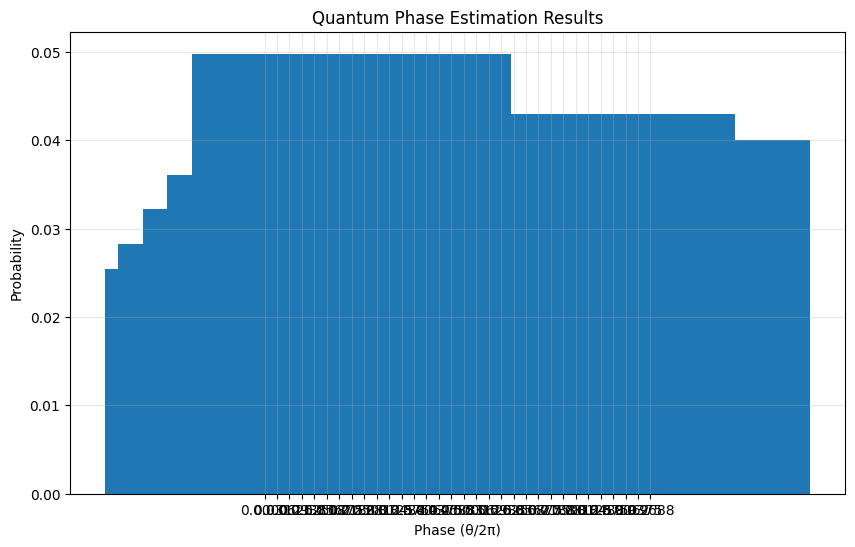

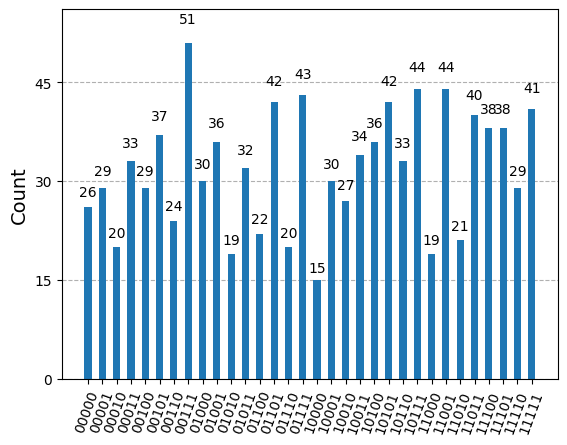

In [14]:
# Quantum Phase Estimation implementation on Quantum Inspire's Starmon-7 backend

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_quantuminspire.qi_provider import QIProvider
import numpy as np
import matplotlib.pyplot as plt

# Login to Quantum Inspire
!qi login "https://api.quantum-inspire.com"

# Initialize the QI Provider
provider = QIProvider()
backend = provider.get_backend('Starmon-7')

# Define the number of qubits for precision and the target qubit
precision_qubits = 5  # Number of qubits for precision
target_qubit = 1      # Number of qubits for the eigenstate

# Total number of qubits
total_qubits = precision_qubits + target_qubit

# Create a quantum circuit
qpe_circuit = QuantumCircuit(total_qubits, precision_qubits)

# Initialize the target qubit (qubit 3) to |1⟩ - eigenstate of the phase gate
qpe_circuit.x(precision_qubits)

# Apply Hadamard gates to create superposition on precision qubits
for i in range(precision_qubits):
    qpe_circuit.h(i)

# Add barrier for clarity
qpe_circuit.barrier()

# Apply controlled-U operations
# We'll use a T gate (phase rotation of π/4) as our unitary operator
# For QPE, we need to apply U^(2^j) for each control qubit j
for i in range(precision_qubits):
    repetitions = 2**i
    for _ in range(repetitions):
        qpe_circuit.cp(np.pi/4, i, precision_qubits)  # Controlled-T gate (phase = π/4)

# Add barrier for clarity
qpe_circuit.barrier()

# Apply inverse QFT to precision qubits
for i in range(precision_qubits//2):
    qpe_circuit.swap(i, precision_qubits-i-1)

for i in range(precision_qubits):
    qpe_circuit.h(i)
    for j in range(i+1, precision_qubits):
        qpe_circuit.cp(-np.pi/float(2**(j-i)), j, i)

# Measure precision qubits
qpe_circuit.measure(range(precision_qubits), range(precision_qubits))

# Display the circuit
# print("Quantum Phase Estimation Circuit:")
# print(qpe_circuit)
 ## additional code from me
starmon7_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz']
qubit_priority_list = [3, 6, 4, 1, 5, 0, 2]

# Transpile the circuit for the Starmon-7 backend
transpiled_circuit = transpile(qpe_circuit, backend, initial_layout=qubit_priority_list[0:qpe_circuit.num_qubits], basis_gates=starmon7_basis_gates)
# transpiled_circuit = transpile(qpe_circuit, backend)
# Execute the circuit on the Starmon-7 backend
job = backend.run(transpiled_circuit, shots=1024)

# Get the results
result = job.result()
counts = result.get_counts()

# Display the measurement results
print("\nMeasurement results:", counts)

# Process and interpret results
phase_values = {}
for bitstring, count in counts.items():
    # Convert bitstring to phase value (divide by 2^n)
    phase = int(bitstring, 2) / (2**precision_qubits)
    # Store with probability
    if phase in phase_values:
        phase_values[phase] += count/1024
    else:
        phase_values[phase] = count/1024

print("\nEstimated phases and probabilities:")
for phase, prob in sorted(phase_values.items()):
    print(f"Phase: {phase:.4f} (≈ {phase*2*np.pi:.4f} radians), Probability: {prob:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(phase_values.keys(), phase_values.values())
plt.xlabel('Phase (θ/2π)')
plt.ylabel('Probability')
plt.title('Quantum Phase Estimation Results')
plt.xticks([i/2**precision_qubits for i in range(2**precision_qubits)])
plt.grid(True, alpha=0.3)
plt.show()

# Also show histogram of raw measurements
plot_histogram(counts)